## The 2013 Boston Marathon: A Clustering Story
by Michael Klear<br><br>
    This is an exercise in cluster analysis using <a href='https://github.com/llimllib/bostonmarathon'>this dataset</a> of Boston Marathon race results. Thanks to <a href='https://github.com/llimllib'>Bill Mill</a> for gathering this data!<br>
    The idea here is to run a cluster analysis on the data and see what interesting results we can get.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.cluster import SpectralClustering, AffinityPropagation, KMeans, MeanShift, estimate_bandwidth
from scipy.spatial.distance import cdist
sns.set_style('darkgrid')
plt.rcParams['image.cmap'] = 'autumn'

The data includes a number of split times. I'll drop the rows where split times are missing, less than 1% of the results.

In [2]:
df = pd.read_csv('results13.csv')
splits = ['5k', '10k', '20k', 'half', '25k', '35k', '40k']
cond = pd.DataFrame()
for split in splits:
    cond[split] = (df[split] == '-')
    
df = df[~cond.any(axis=1)].copy() #drop rows with null splits values
splits.append('official')

I'll convert the split times to numeric types, and flag "male" and "wheelchair" binary features with 1 and 0 values.

In [3]:
data = pd.DataFrame(index=df.index)
        
data['5k'] = df['5k'].apply(float)
data['10k'] = df['10k'].apply(float)
data['20k'] = df['20k'].apply(float)
data['half'] = df['half'].apply(float)
data['25k'] = df['25k'].apply(float)
data['35k'] = df['35k'].apply(float)
data['40k'] = df['40k'].apply(float)
data['official'] = df['official'].apply(float)
data['pace'] = df.pace
data['age'] = df.age

data['male'] = np.where(df.gender == 'M', 1, 0)

def get_wheelchair(strng):
    """Takes a bib number in string format. Returns 1 when
    starts with "W" (wheelchair), otherwise 0.
    """
    if strng[0] == 'W':
        return 1
    else:
        return 0
    
data['wheelchair'] = df.bib.apply(get_wheelchair)

df = pd.concat([df, data[['male', 'wheelchair']]], axis=1)

The splits are interesting but super colinear. I'll run principal component analysis on them to reduce dimensionality:

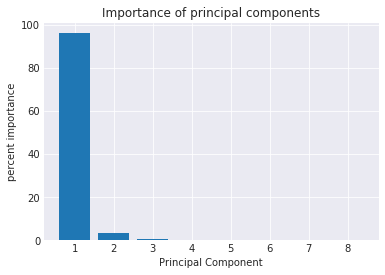

In [4]:
splt = data[splits]
#Scale the splits
splt_scl = StandardScaler()
splt_scl.fit(splt)
splt = splt_scl.transform(splt)

#Run PCA
splt_pca = PCA()
splt_comp = splt_pca.fit_transform(splt)
vars_ = splt_pca.explained_variance_ratio_
plt.bar(range(1, 1+vars_.shape[0]), 100*vars_);
plt.title('Importance of principal components')
plt.xlabel('Principal Component')
plt.ylabel('percent importance')
plt.show();

We can see that the first PC contains the vast majority of information, while the second retains most of what's left over. I'll hold on to just the first two PC's.<br><br>
## Features
<br>
I'll exclude gender and ability status in my cluster analysis and withhold those binary features so we can see if our clusters can identify differences with those groups.

In [5]:
features = pd.DataFrame(index=df.index)

#Grab PA's.
features['splits1'] = splt_comp[:, 0]
features['splits2'] = splt_comp[:, 1]
#And age.
features['age'] = df.age
#Create a dataframe and normalize vectors for cluster analysis.
features = pd.DataFrame(index=df.index, columns=features.columns, data=normalize(features))
features.head()

,splits1,splits2,age
0,0.477825,0.028370,0.877997
1,0.289396,-0.002562,0.957206
2,0.368394,-0.006288,0.929648
3,0.428884,0.019111,0.903158
4,0.368386,0.016995,0.929518


## Selecting a Number of Clusters
The KMeans cluster analysis can give any number of clusters, so it's important to choose k (the number of clusters) well. An "elbow plot" is a common way of doing this. Here I use three methods to create elbow plots:
 1. Inertia. This is a built-in value in the SKLearn KMeans package.
 2. Distortion. This is a common one. Measures mean distance from cluster centers to cluster members.
 3. Score. This is a method on the SKLearn KMeans package to rate performance.
 
The idea with the "elbow plot" is to look for k such that additional k provide little additional benefit. (I rescale and flip around these values so we can look at them next to each other.)

In [6]:
inrts = []
ks = []
distortions = []
scores = []
for k in range(2, 10):
    ks.append(k)
    clstr = KMeans(n_clusters=k, random_state=k*k)
    X = features[['splits1', 'splits2', 'age']]
    clstr = clstr.fit(X)
    inrts.append(clstr.inertia_)
    distortions.append(sum(np.min(cdist(X, clstr.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    scores.append(clstr.score(X))

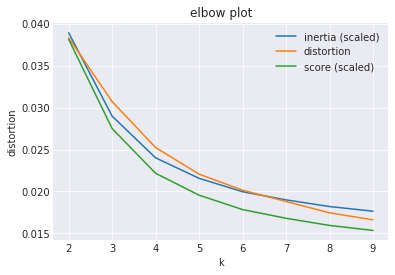

In [7]:
plt.plot(ks, (np.array(inrts)+20)/1510, label='inertia (scaled)');    
plt.plot(ks, distortions, label='distortion');   
plt.plot(ks, (-np.array(scores)+15)/1410, label='score (scaled)');
plt.title('elbow plot')
plt.xlabel('k');
plt.ylabel('distortion');
plt.legend();
plt.show();

There's no well defined "elbow" here, but k=4 is probably the elbowy-est looking k all for all three curves. Let's train up a k=4 means cluster model and see what happens!

In [8]:
clstr = KMeans(n_clusters=4, random_state=42)
clstr = clstr.fit(features)

In [9]:
def view_clusters(df, features, preds):
    """Takes a dataframe in normal space (df), a frame with corresponding features (features),
    and cluster assignments (preds). Plots all kinds of good stuff.
    Returns cluster assignments for fun.
    """
    df['cluster'] = preds
    features['cluster'] = preds
    plt.figure(figsize=(10, 7))
    plt.title('finish time vs. age')
    plt.scatter(df['official'], df.age, c=features.cluster)
    plt.xlabel('finish time');
    plt.ylabel('age');
    plt.show();
    plt.figure(figsize=(10, 7))
    plt.scatter(features['splits1'], df.age, c=features.cluster)
    plt.xlabel('splits PC1')
    plt.ylabel('age')
    plt.title('Splits Principal Component 1 vs. age')
    plt.show();
    clusters = list(df.cluster.unique())
    plt.figure(figsize=(10, 6))
    for clust in clusters:
        plt.hist(df[df.cluster==clust].official, label='cluster {}'.format(clust+1), alpha=.8)

    plt.hist(df.official, label='total distribution', alpha=.35, bins=30)
    plt.title('Finish time by cluster')
    plt.legend();
    plt.show();

    fig, ax = plt.subplots(1, len(clusters), figsize=(14, 5));
    for clust in clusters:
        cluster = df[df.cluster==clust]
        men = len(cluster[cluster.male==1])
        women = len(cluster) - men
        wheelchair = len(cluster[cluster.wheelchair == 1])
        foot = len(cluster) - wheelchair
        ax[clust].bar([1, 2, 3], [men, women, wheelchair])
        ax[clust].set_title('cluster {}'.format(clust+1))
        ax[clust].set_xticks([1, 2, 3])
        ax[clust].set_xticklabels(['men', 'women', 'chair'])
    plt.show();
    return df.cluster

## Clusters
Let's see what these clusters look like.

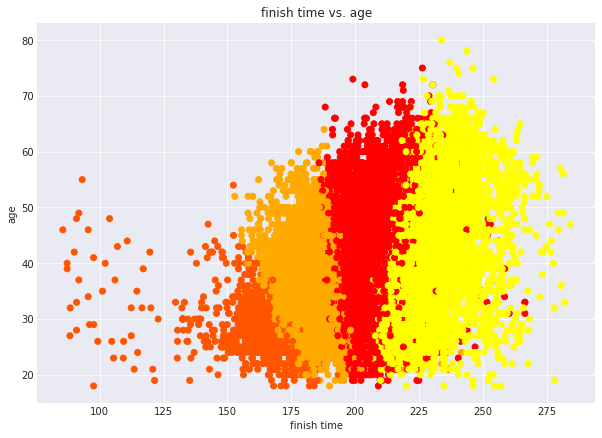

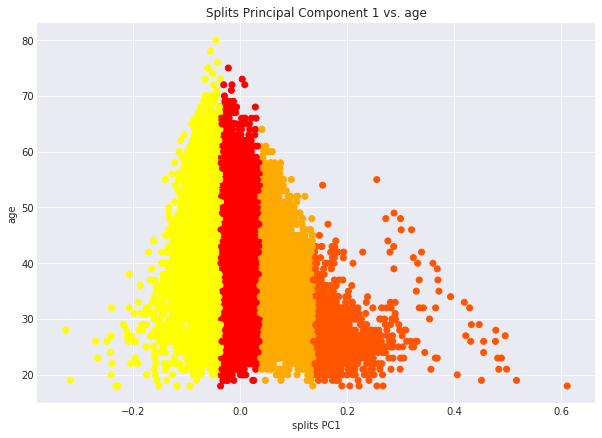

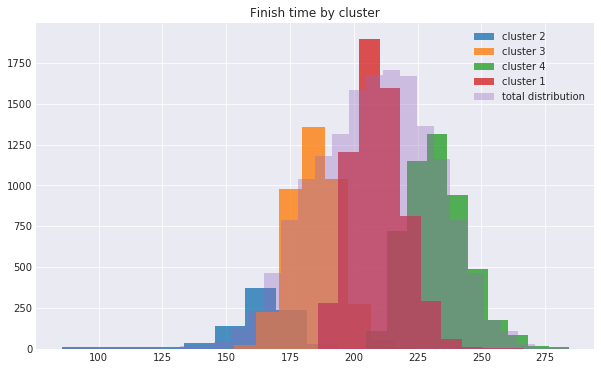

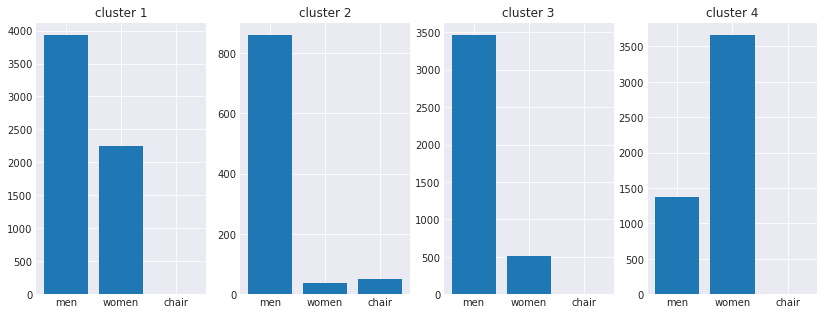

In [10]:
preds = clstr.predict(features[['splits1', 'splits2', 'age']])
tuf = view_clusters(df, features, preds)

We can see that this method has split clusters into groups of finishing time with some overlap. Interestingly, it's captures all of the wheelchair competitors in one cluster (cluster 2) and a majority-women cluster (cluster 4).<br>
I'll try something called spectral clustering. This uses a similarity matrix and computes eigenvectors to create clusters. The matrices are nxn in size where n is the number of samples, so the computation is memory-intensive. To avoid crashing my computer, I need to take a sample of 30% of all the finishers to do the computation.


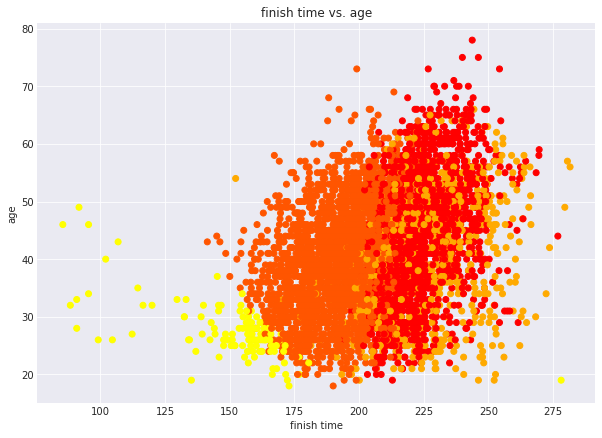

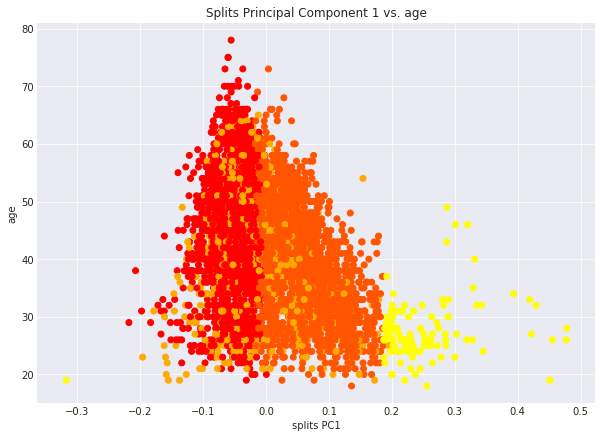

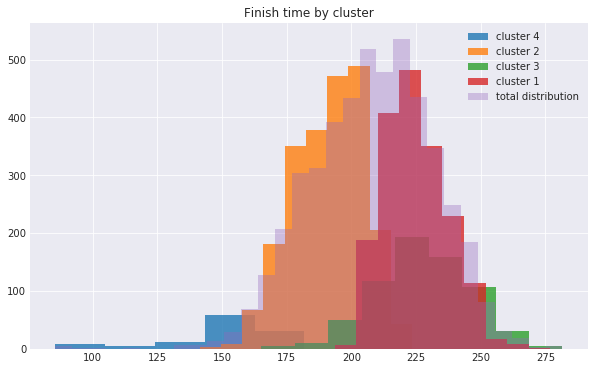

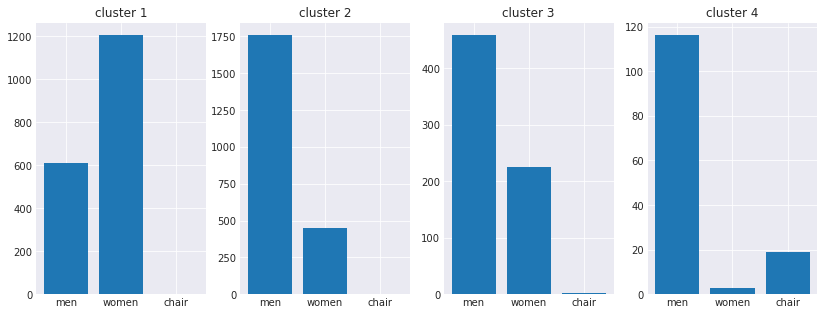

In [11]:
spectral = SpectralClustering(n_clusters=4)
X = features[['splits1', 'splits2', 'age']].sample(frac=.3, random_state=42)
indcs = X.index
preds = spectral.fit_predict(X)
braf = view_clusters(df.loc[indcs], X, preds)

There may be something I've missed, but this version looks a lot noisier with little additional benefit. Spectral analysis seems popular for image analysis where the features dimensions are high, so this may be the wrong application for it.<br><br>
## Mean Shift
<br>Let's try the mean shift algorithm. This method produces its own number of clusters, so we'll see how many come out. SKLearn also provides us with a way of estimating the right value for the bandwidth hyperparameter

In [12]:
X = features[['splits1', 'splits2', 'age']]
#Estimate bandwidth
bandwidth = estimate_bandwidth(X)

In [13]:
#Train up our model. Took several minutes on my machine.
mshift = MeanShift(bandwidth=bandwidth, n_jobs=-2)
mshift.fit(X)

MeanShift(bandwidth=0.051088327077768218, bin_seeding=False, cluster_all=True,
     min_bin_freq=1, n_jobs=-2, seeds=None)

In [14]:
#We can see 5 clusters come out.
mshift.cluster_centers_.shape

(5, 3)

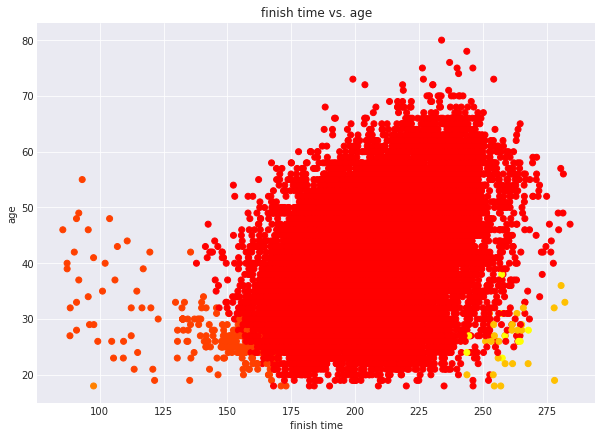

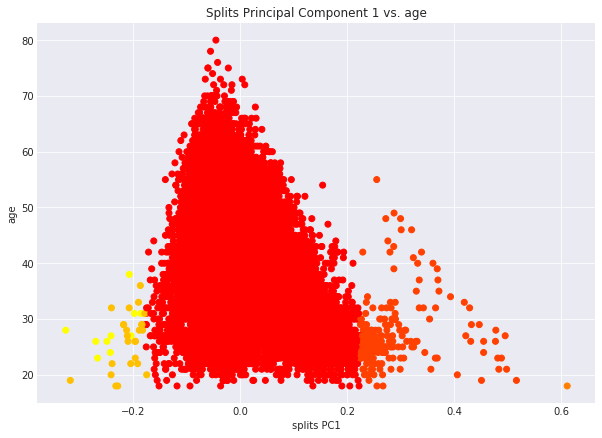

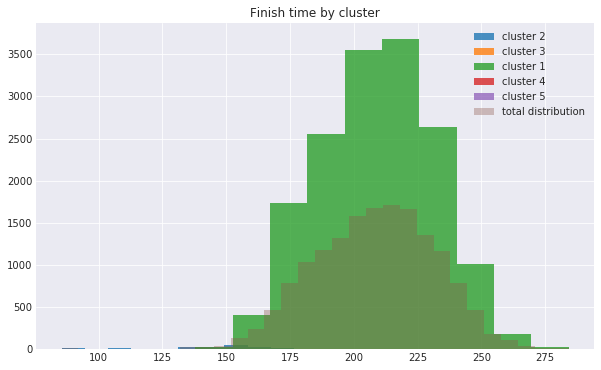

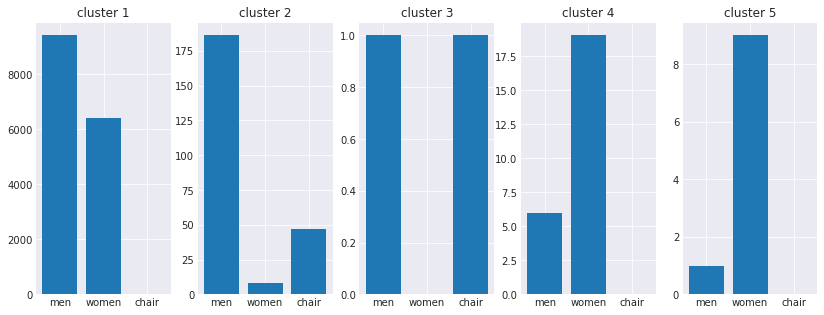

In [15]:
#Let's take a look:
preds = mshift.predict(X)
braf = view_clusters(df, X, preds)

We can see that one giant cluster has appeared that captures the majority of our data. The other clusters are much smaller. One cluster includes just one racer... Let's take a closer look at that one-man cluster. His name is Nathaniel Arkley.

In [16]:
df['meanshift_clusters'] = preds
solo = df[df.meanshift_clusters == 2]
print(solo[['name', 'age', 'gender', 'official']])

                 name  age gender  official
34  Arkley, Nathenial   18      M     97.58


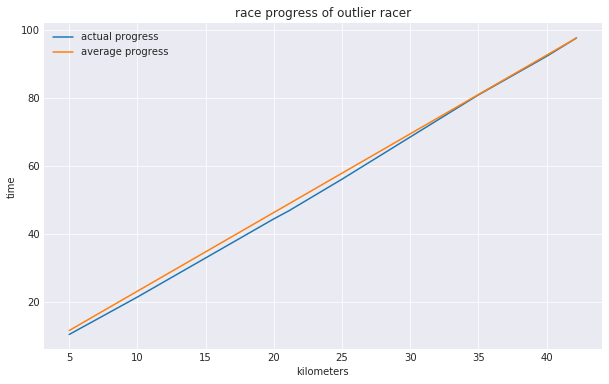

In [17]:
marks = np.array([5, 10, 20, 21.09, 25, 35, 40, 42.195])
times = solo[splits].values[0]
pace = times[-1] /42.195
expected_times = pace * marks
plt.figure(figsize=(10, 6))
plt.plot(marks, times, label='actual progress');
plt.plot(marks, expected_times, label='average progress');
plt.title('race progress of outlier racer');
plt.xlabel('kilometers');
plt.legend();
plt.ylabel('time');

Looking at his split times, we can see that his performance (pace) is super consistent throughout the race. This doesn't appear to be the source of differentiation.<br> I do see that he's 18 years old, so maybe his age sets him apart. Let's see what other racers in his age group look like.

In [18]:
df[(df.wheelchair==1) & (df.age < 21)][['age', 'name', 'official']]

,age,name,official
34,18,"Arkley, Nathenial",97.58
65,19,"Roy, Laurence D. III",135.23
66,19,"Martin, Raymond",121.48
100,20,"Moore, Jill N.",146.33


Wow. He has the best wheelchair time by far for competitors under 21 years old.

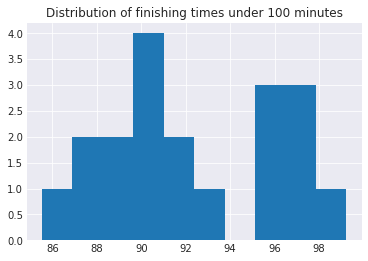

In [19]:
df[(df.wheelchair==1) & (df.official < 100)].official.hist();
plt.title('Distribution of finishing times under 100 minutes')
plt.show();

In [20]:
df.loc[df[df.wheelchair==1].official.sort_values().index][['name', 'age', 'official', 'division']].head(17)

,name,age,official,division
31,"Yamamoto, Hiroyuki",46,85.53,1
11,"Van Dyk, Ernst F.",40,87.20,2
4,"Hokinoue, Kota",39,87.22,3
13,"Hug, Marcel E.",27,88.32,4
3,"Fearnley, Kurt H.",32,88.43,5
6,"Soejima, Masazumi",42,90.02,6
20,"Lemeunier, Denis",48,90.88,7
0,"Cassidy, Josh R.",28,90.90,9
19,"Madera, Jorge",33,90.90,8
8,"Schabort, Krige",49,91.78,11


We can see that Nathaniel is an exceptional racer; he placed 17th overall and those ahead of him are generally far older. He has a lot of potential as a competitor in future races.

## Conclusion
We got some interesting results from cluster analysis. Though the KMeans algorithm gave us nicer groups to look at, the mean shift algorithm gave us perhaps the most interesting and insightful story. This highlights mean shift's ability to capture extremely small clusters, unconstrained by a user-input of k-clusters.